In [1]:
# imports
from matplotlib import pyplot as plt
import pandas as pd
from hmmlearn import hmm
import numpy as np
import sys
import time
sys.path.insert(1, '/mnt/c/Users/dalli/source/acme_senior/_projectV3/CarKalmanFilter/')


import cleaner
import filter
from kalman import KalmanFilter

wsl = True

# Load Data

In [2]:
if wsl:
    parent = '/mnt/c/Users/dalli/source/acme_senior/_projectV3/CarKalmanFilter/.data'
else:
    parent = ".data"
data_dict = cleaner.clean_dict(cleaner.load_data(parent, exclude_test=["PVS 7", "PVS 8"], exclude_val=["PVS 9"]))

In [3]:
cleaner.print_structure(data_dict)


  train: 
 	 t_gps: 
 		 PVS 1: (1458, 11)
 		 PVS 2: (1551, 11)
 		 PVS 3: (1316, 11)
 		 PVS 4: (1432, 11)
 		 PVS 5: (1263, 11)
 		 PVS 6: (915, 11)
 	 gps_mpu_left: 
 		 PVS 1: (144036, 26)
 		 PVS 2: (124684, 26)
 		 PVS 3: (105816, 26)
 		 PVS 4: (132492, 26)
 		 PVS 5: (133877, 26)
 		 PVS 6: (96279, 26)
 	 gps_mpu_right: 
 		 PVS 1: (144036, 26)
 		 PVS 2: (124684, 26)
 		 PVS 3: (105816, 26)
 		 PVS 4: (132492, 26)
 		 PVS 5: (133877, 26)
 		 PVS 6: (96279, 26)
 	 labels: 
 		 PVS 1: (144036, 14)
 		 PVS 2: (124684, 14)
 		 PVS 3: (105816, 14)
 		 PVS 4: (132492, 14)
 		 PVS 5: (133877, 14)
 		 PVS 6: (96279, 14)
 	 folders: 6
  val: 
 	 t_gps: 
 		 PVS 9: (999, 11)
 	 gps_mpu_left: 
 		 PVS 9: (91555, 26)
 	 gps_mpu_right: 
 		 PVS 9: (91555, 26)
 	 labels: 
 		 PVS 9: (91555, 14)
 	 folders: 1
  test: 
 	 t_gps: 
 		 PVS 7: (1281, 11)
 		 PVS 8: (1134, 11)
 	 gps_mpu_left: 
 		 PVS 7: (128548, 26)
 		 PVS 8: (123618, 26)
 	 gps_mpu_right: 
 		 PVS 7: (128548, 26)
 		 PVS 8:

## Clean and Format Data

In [4]:
filter.add_smoothed_cols(data_dict, window=200)

{'train': {'t_gps': {'PVS 1':          timestamp   latitude  longitude   elevation  accuracy    bearing  \
   0     1.577219e+09 -27.717812 -51.098895  948.770836      24.0  159.73294   
   10    1.577219e+09 -27.717840 -51.098877  986.167056       4.0  315.85168   
   11    1.577219e+09 -27.717840 -51.098877  985.918529       4.0  316.12387   
   12    1.577219e+09 -27.717840 -51.098876  985.829575       4.0  316.15497   
   13    1.577219e+09 -27.717839 -51.098873  985.567538       4.0  315.31592   
   ...            ...        ...        ...         ...       ...        ...   
   1462  1.577220e+09 -27.717778 -51.099069  980.865571       4.0  130.51640   
   1463  1.577220e+09 -27.717773 -51.099072  981.469505       6.0  130.51602   
   1464  1.577220e+09 -27.717773 -51.099078  979.980588       6.0  194.52164   
   1465  1.577220e+09 -27.717777 -51.099073  979.903556       6.0  195.58694   
   1466  1.577220e+09 -27.717777 -51.099070  979.779629       6.0  195.58623   
   
         

In [5]:
len(data_dict["train"]["t_gps"]["PVS 1"])

1458

In [6]:
def build_z_dash(df, type="train", road="good_road_left"):
    """
    Builds a 1 column dataset from the given dictionary of dataframes
    timestamp
    latitude
    longitude
    elevation
    acc_x_dash_smooth
    acc_y_dash_smooth
    acc_z_dash_smooth

    :param df: dataframe
    :param type: string

    :return: dataframe with only the acc_z_dash column
    :return: list of lengths
    """
    result = None
    lengths = []
    for folder in df[type]["gps_mpu_left"].keys():
        pvsi = df[type]["gps_mpu_left"][folder]
        labels = df[type]["labels"][folder][road]
        indices = labels[labels == 1].index
        if road == "good_road_left":
            # also add indices where "regular_road_left" is 1
            reg_labels = df[type]["labels"][folder]["regular_road_left"]
            indices = indices.append(reg_labels[reg_labels == 1].index)

        new_data = pvsi.loc[indices]["acc_z_dash"]
        lengths.append(len(new_data))

        if result is None:
            result = new_data
        else:
            # append on the same column
            result = pd.concat([result, new_data], axis=0)           
    return result - 9.8, lengths
    


def build_gps_data(df, type="train"):
    """
    Builds a 6 column dataset from the given dataframe

    :param df: dataframe
    :param type: string

    :return: dataframe with only the acc_z_dash column
    :return: list of lengths
    """
    result = {}
    for folder in df[type]["gps_mpu_left"].keys():
        pvsi = df[type]["gps_mpu_left"][folder][["timestamp", "meters_latitude", "meters_longitude", "acc_x_dash_smooth", "acc_y_dash_smooth", "acc_z_dash_smooth"]]
        elevation = df[type]["t_gps"][folder][["timestamp", "meters_elevation"]]

        # merge the two dataframes on timestamp then remove timestamp
        pvsi = pd.merge(pvsi, elevation, on="timestamp")
        pvsi = pvsi.drop(columns=["timestamp"])

        result[folder] = pvsi
    return result


train_dict = {
    "good": build_z_dash(data_dict, type="train", road="good_road_left"),
    "bad": build_z_dash(data_dict, type="train", road="bad_road_left")
}

test_dict = {
    "good": build_z_dash(data_dict, type="test", road="good_road_left"),
    "bad": build_z_dash(data_dict, type="test", road="bad_road_left")
}

val_dict = {
    "good": build_z_dash(data_dict, type="val", road="good_road_left"),
    "bad": build_z_dash(data_dict, type="val", road="bad_road_left")
}

In [25]:
# print(test_dict["good"])
g = len(test_dict["good"][0])
b = len(test_dict["bad"][0])
print(g / (g + b))
print(b / (g + b))

0.7971455311183903
0.20285446888160974


# HMM to Predict Road Quality

In [7]:
model_list = []
n_list = range(2, 9)

# iterate over the number of components
for nc in n_list:
    print(f"\n{nc} components:")
    models = {}
    num_models = 2

    # iterate over the datasets
    for key in train_dict.keys():
        # make data an array
        data, lengths = train_dict[key]
        data = data.values.reshape(-1, 1)
        print(key, end=": ")

        best_log = -np.inf
        best_model = None
        # iterate over the number of models
        for i in range(num_models):

            # Initialize and train the model
            model = hmm.GMMHMM(n_components=nc, covariance_type="diag")
            model.fit(data, lengths=lengths)

            # Update the best model
            log_likelihood = model.monitor_.history[-1]
            if log_likelihood > best_log:
                best_log = log_likelihood
                best_model = model
            print(i, end=", ")
        models[key] = best_model
    model_list.append(models)


2 components:
good: 0, 1, bad: 0, 1, 
3 components:
good: 0, 1, bad: 0, 1, 
4 components:
good: 0, 1, bad: 0, 1, 
5 components:
good: 0, 1, bad: 0, 1, 
6 components:
good: 0, 1, bad: 0, 1, 
7 components:
good: 0, 1, bad: 0, 1, 
8 components:
good: 0, 1, bad: 0, 1, 

## Evaluate

In [14]:
def predict(mfcc_coeffs, index, scale=1.0):
    """
    Predict the word from the given mfcc coefficients
    
    Parameters
    ----------
    mfcc_coeffs : ndarray of shape (M,)
        The mfcc coefficients for the word to be predicted
    index : int
        The index of the model in the list of models
        
    Returns
    -------
    word : str
        The predicted road quality
    """
    # find the log probability density of the given mfcc coefficients
    log_prob = {}
    for key in model_list[index].keys():
        rescale = scale if key == "good" else 1.0
        log_prob[key] = model_list[index][key].score(mfcc_coeffs) / rescale
    
    # return the class with the highest probability
    return max(log_prob, key=log_prob.get)



time_window = 30 # seconds
time_window *= 1000
n_list = range(2, 9)

for j, nc in enumerate(n_list):
    print("Number of components:", nc)
    for key in test_dict.keys():
        correct = 0
        incorrect = 0
        test_data, _ = test_dict[key]
        test_data = test_data.values.reshape(-1, 1)

        # iterate over threshold scales
        for scale in [1+0.02*i for i in range(10)]:
            # iterate over test_data in groups of 10000
            for i in range(0, len(test_data), time_window):
                item = test_data[i:i+time_window]
                prediction = predict(item, j, scale=scale)
                if prediction == key:
                    correct += 1
                else:
                    incorrect += 1
            accuracy = round(correct/(correct+incorrect), 3)
            status = "high" if accuracy > 0.7 else "--"
            print(f"Accuracy for {key}, rescale at {round(scale,2)}: {accuracy} \t({status})")
        print()

Number of components: 2
Accuracy for good, rescale at 1.0: 0.143 	(--)
Accuracy for good, rescale at 1.02: 0.286 	(--)
Accuracy for good, rescale at 1.04: 0.429 	(--)
Accuracy for good, rescale at 1.06: 0.571 	(--)
Accuracy for good, rescale at 1.08: 0.657 	(--)
Accuracy for good, rescale at 1.1: 0.714 	(high)
Accuracy for good, rescale at 1.12: 0.755 	(high)
Accuracy for good, rescale at 1.14: 0.786 	(high)
Accuracy for good, rescale at 1.16: 0.81 	(high)
Accuracy for good, rescale at 1.18: 0.829 	(high)

Accuracy for bad, rescale at 1.0: 1.0 	(high)
Accuracy for bad, rescale at 1.02: 1.0 	(high)
Accuracy for bad, rescale at 1.04: 1.0 	(high)
Accuracy for bad, rescale at 1.06: 0.875 	(high)
Accuracy for bad, rescale at 1.08: 0.7 	(--)
Accuracy for bad, rescale at 1.1: 0.583 	(--)
Accuracy for bad, rescale at 1.12: 0.5 	(--)
Accuracy for bad, rescale at 1.14: 0.438 	(--)
Accuracy for bad, rescale at 1.16: 0.389 	(--)
Accuracy for bad, rescale at 1.18: 0.35 	(--)

Number of components: 

No rescaling (scale = 1) allows for the best prediction of road quality.

In [17]:
best = {"good": model_list[4]["good"], 
        "bad": model_list[4]["bad"]}

In [20]:
def best_predict(mfcc_coeffs, scale=1.0):
    log_prob = {}
    for key in best.keys():
        rescale = scale if key == "good" else 1.0
        log_prob[key] = best[key].score(mfcc_coeffs) / rescale
    return max(log_prob, key=log_prob.get)

time_window = 30000
preds = []
corrects = []
for key in test_dict.keys():
    correct = 0
    incorrect = 0
    test_data, _ = test_dict[key]

    # iterate over test_data in groups of 10000
    mini_preds = []
    mini_corrects = []
    test_data = test_data.values.reshape(-1, 1)
    for i in range(0, len(test_data), time_window):
        item = test_data[i:i+time_window]
        prediction = best_predict(item, scale=1.02)
        ith = 0 if prediction == "good" else 1
        jth = 0 if key == "good" else 1
        mini_preds.append([ith for _ in range(time_window)])
        mini_corrects.append([jth for _ in range(time_window)])
        if prediction == key:
            correct += 1
        else:
            incorrect += 1
    preds.append(mini_preds)
    corrects.append(mini_corrects)
    
    print("Accuracy for", key, ":", correct/(correct+incorrect))

Accuracy for good : 0.8571428571428571
Accuracy for bad : 1.0


In [27]:
0.8*0.8571428571428571 + 0.2*1

0.8857142857142857

## Visualize Performance

[11459, 8641]
[1395, 3720]


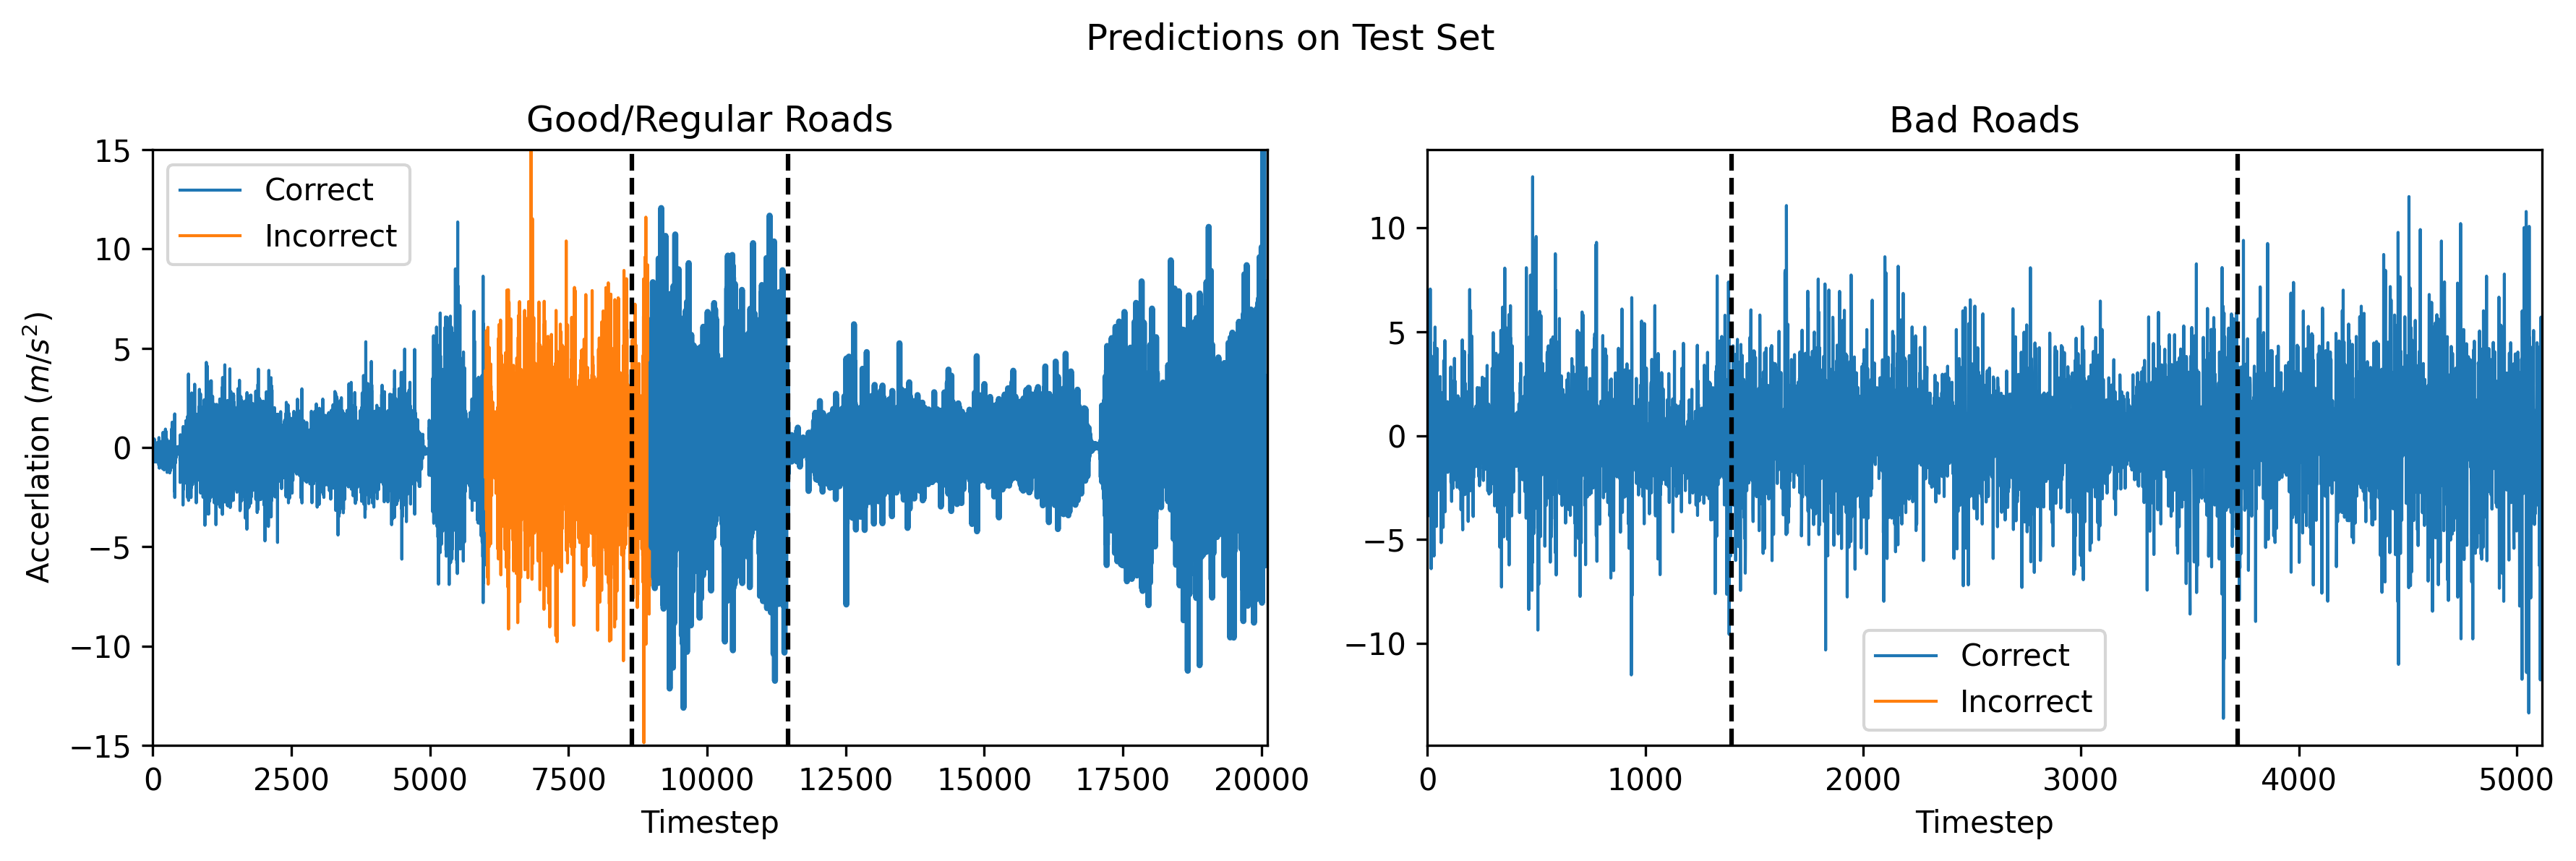

In [21]:
alpha = 10
beta = 5
ds = 10
lw = 1
c_correct = "#1f77b4"
c_wrong = "#ff7f0e"
c_split = "k"

# isolate the data by type
good_array = test_dict["good"][0].values[::ds]
bad_array = test_dict["bad"][0].values[::ds]
good_splits = [split // ds for split in test_dict["good"][1]]
bad_splits = [split // ds for split in test_dict["bad"][1]]
good_pred = np.array(preds[0]).flatten()[::ds]
good_correct = np.array(corrects[0]).flatten()[::ds]
bad_pred = np.array(preds[1]).flatten()[::ds]
bad_correct = np.array(corrects[1]).flatten()[::ds]

print(good_splits)
print(bad_splits)

# find where good_pred switches from 0 to 1 or 1 to 0
def find_switch_points(array):
    switch_points = []
    prev_value = None
    
    for i, value in enumerate(array):
        if prev_value is not None and value != prev_value:
            switch_points.append(i)
        prev_value = value
    
    return switch_points


# plot test data
plt.figure(figsize=(12, 4), dpi=300)
plt.subplot(121)

switch_points = np.array(find_switch_points(good_pred))
color_map = {0: c_correct, 1: c_wrong}

# Plot each segment separately
start_index = 0
count = 0
lines = {}
for switch_index in switch_points:
    color = color_map[good_pred[start_index]]
    line, = plt.plot(range(start_index, switch_index), good_array[start_index:switch_index], color=color, linewidth=lw)
    if count < 2:
        lines[line] = 'Correct' if color == c_correct else 'Incorrect'
        count += 1
    start_index = switch_index
plt.plot(range(start_index, start_index + len(good_array[start_index:])), good_array[start_index:], color=color_map[good_pred[start_index]], linewidth=2)

# Plot good road data classification
for split in good_splits:
    plt.axvline(x=split, color='k', linestyle='--')
plt.title("Good/Regular Roads")
plt.xlim(0, len(good_array))
plt.ylim(-15, 15)
plt.xlabel("Timestep")
plt.ylabel("Accerlation ($m/s^2$)")
plt.legend(lines.keys(), lines.values(), loc='best')


# plot bad road data classification
plt.subplot(122)
plt.plot(bad_array, label="Z Acceleartion", color=c_correct, linewidth=lw)
for split in bad_splits:
    plt.axvline(x=split, color='k', linestyle='--')
plt.title("Bad Roads")
plt.xlim(0, len(bad_array))
plt.xlabel("Timestep")
plt.legend(lines.keys(), lines.values(), loc='best')

plt.suptitle("Predictions on Test Set")
plt.tight_layout()
plt.show()

In [12]:
def pretty_print_parameters(parameters):
    """
    Pretty print the parameters of the model

    :param parameters: dictionary
    """
    for key, value in parameters.items():
        if isinstance(value, str):
            print(f"{key}: '{value}'")
        elif isinstance(value, bool):
            print(f"{key}: {str(value).lower()}")
        elif isinstance(value, (int, float)):
            print(f"{key}: {value}")
        elif isinstance(value, list):
            print(f"{key}:")
            for sub_value in value:
                if isinstance(sub_value, list):
                    for sub_sub_value in sub_value:
                        print(f"  - {sub_sub_value}")
                else:
                    print(f"  - {sub_value}")
        elif isinstance(value, np.ndarray):
            print(f"{key}:")
            for sub_value in value:
                for sub_sub_value in sub_value:
                    print(f"  - {sub_sub_value}")
        else:
            print(f"{key}: {value}")

def compare_parameter_sets(parameters1, parameters2):
    """
    Compare two sets of parameters

    :param parameters1: dictionary
    :param parameters2: dictionary
    """
    max_key_length = max(len(key) for key in parameters1.keys())

    print("Parameters Set 1".ljust(max_key_length + 15), "Parameters Set 2")
    print("-" * (max_key_length + 15), " " * 5, "-" * max_key_length)

    for key in parameters1.keys():
        value1 = parameters1[key]
        value2 = parameters2[key] if key in parameters2 else None

        if isinstance(value1, (int, float, str, bool)):
            print(f"{key}: {str(value1).ljust(max_key_length)}", " " * 5, f"{key}: {value2}")
        elif isinstance(value1, list):
            print(f"{key}:")
            for sub_value1, sub_value2 in zip(value1, value2 or []):
                print(f"  - {str(sub_value1).ljust(max_key_length - 3)}", " " * 8, f"  - {sub_value2}")
        elif isinstance(value1, np.ndarray):
            print(f"{key}:")
            if value2 is not None and value1.shape == value2.shape:
                flattened_value1 = value1.flatten()
                flattened_value2 = value2.flatten()
                for sub_value1, sub_value2 in zip(flattened_value1, flattened_value2):
                    print(f"  - {str(sub_value1).ljust(max_key_length - 3)}", " " * 8, f"  - {sub_value2}")
            else:
                print("  Arrays are not of the same shape or one of them is None")
        else:
            print(f"{key}: {value1}", " " * 5, f"{key}: {value2}")


# Print the parameters of the models and their comparison
for _n in range(len(model_list)):
    good_params = model_list[_n]["good"].get_params()
    bad_params = model_list[_n]["bad"].get_params()
    print(f"\nModel {_n + 2} components\n")
    compare_parameter_sets(good_params, bad_params)


Model 2 components

Parameters Set 1               Parameters Set 2
------------------------------       ---------------
algorithm: viterbi               algorithm: viterbi
covariance_type: diag                  covariance_type: diag
covars_prior:
  - -1.5                    - -1.5
  - -1.5                    - -1.5
covars_weight:
  - 0.0                     - 0.0
  - 0.0                     - 0.0
implementation: log                   implementation: log
init_params: stmcw                 init_params: stmcw
means_prior:
  - 0.0                     - 0.0
  - 0.0                     - 0.0
means_weight:
  - 0.0                     - 0.0
  - 0.0                     - 0.0
min_covar: 0.001                 min_covar: 0.001
n_components: 2                     n_components: 2
n_iter: 10                    n_iter: 10
n_mix: 1                     n_mix: 1
params: stmcw                 params: stmcw
random_state: None       random_state: None
startprob_prior: 1.0                   startprob_prior